In [19]:
from typing import Tuple, List
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from time import time

from rich import print

In [10]:
def read_image_label(path_to_img: str, path_to_txt: str, normilize: bool = False) -> Tuple[np.array, np.array]:
    
    # read image
    image = cv2.imread(path_to_img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_h, img_w = image.shape[:2]
  
    # read .txt file for this image
    with open(path_to_txt, "r") as f:
        txt_file = f.readlines()[0].split()
        cls_idx = txt_file[0]
        coords = txt_file[1:]
        polygon = np.array([[eval(x), eval(y)] for x, y in zip(coords[0::2], coords[1::2])]) # convert list of coordinates to numpy massive
  
    # Convert normilized coordinates of polygons to coordinates of image
    if normilize:
        polygon[:,0] = polygon[:,0]*img_w
        polygon[:,1] = polygon[:,1]*img_h
    return image, polygon.astype(np.int32)


def show_image_mask(img: np.array, polygon: np.array, alpha: float = 0.7):
    
    # Create zero array for mask
    mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    overlay = img.copy()
    
    # Draw polygon on the image and mask
    cv2.fillPoly(mask, pts=[polygon], color=(255, 255, 255))
    cv2.fillPoly(img, pts=[polygon], color=(255, 0, 0))
    cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0, image)
    
    # Plot image with mask
    fig = plt.figure(figsize=(22,18))
    axes = fig.subplots(nrows=1, ncols=2)
    axes[0].imshow(img)
    axes[1].imshow(mask, cmap="Greys_r")
    axes[0].set_title("Original image with mask")
    axes[1].set_title("Mask")
    
    # cv2.imwrite("/Users/vladislavefremov/Disk/Vlad/Job/Lab/Priroda/Datasets/whale_draft/20_04_crop2_DJI_0202_450.png", mask)
    
    plt.show()

In [11]:
image, polygon = read_image_label(path_to_img="img_labels/20_04_crop2_DJI_0202_450.jpg",
                                 path_to_txt="img_labels/20_04_crop2_DJI_0202_450.txt",
                                 normilize=True)

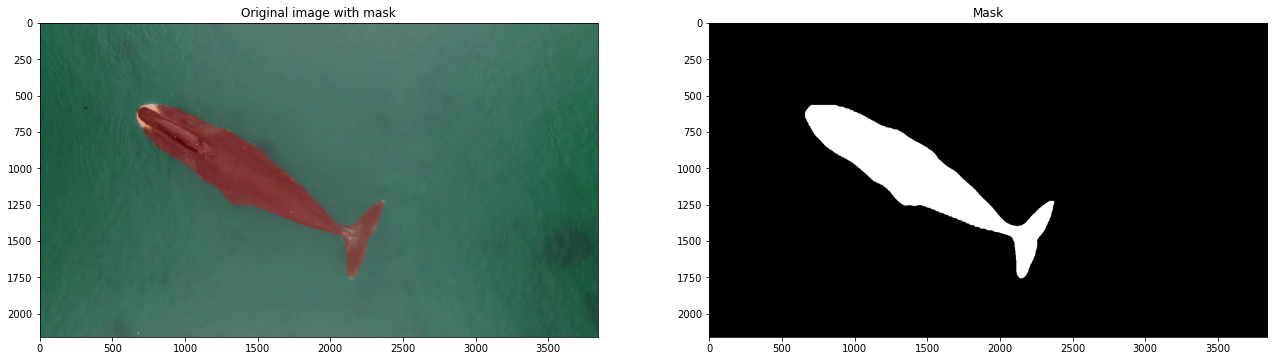

In [12]:
show_image_mask(img=image, polygon=polygon)

In [13]:
mask = cv2.imread("img_labels/20_04_crop2_DJI_0202_450.png", 
                  cv2.IMREAD_GRAYSCALE)

In [14]:
def mask_to_polygon(mask: np.array, report: bool = False) -> List[int]:
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    polygons = []
    for object in contours:
        coords = []

        for point in object:
            coords.append(int(point[0][0]))
            coords.append(int(point[0][1]))
        polygons.append(coords)
    
    if report:
        print(f"Number of points = {len(polygons[0])}")
    
    return np.array(polygons).ravel().tolist()

In [15]:
polygon = mask_to_polygon(mask, report=True)

Number of points = 1444

In [16]:
def reduce_polygon(polygon: np.array, angle_th:int = 0, distance_th: int = 0) -> np.array(List[int]):
    angle_th_rad = np.deg2rad(angle_th)
    points_removed = [0]
    while len(points_removed):
        points_removed = list()
        for i in range(0, len(polygon)-2, 2):
            v01 = polygon[i-1] - polygon[i]
            v12 = polygon[i] - polygon[i+1]
            d01 = np.linalg.norm(v01)
            d12 = np.linalg.norm(v12)
            if d01 < distance_th and d12 < distance_th:
                points_removed.append(i)
                continue
                angle = np.arccos(np.sum(v01*v12) / (d01 * d12))
                if angle < angle_th_rad:
                    points_removed.append(i)
        polygon = np.delete(polygon, points_removed, axis=0)
    return polygon

In [17]:
def show_result_reducing(polygon: List[List[int]]) -> List[Tuple[int, int]]:
    original_polygon = np.array([[x, y] for x, y in zip(polygon[0::2], polygon[1::2])])

    tic = time()
    reduced_polygon = reduce_polygon(original_polygon, angle_th=1, distance_th=20)
    toc = time()

    fig = plt.figure(figsize=(16,5))
    axes = fig.subplots(nrows=1, ncols=2)
    axes[0].scatter(original_polygon[:, 0], original_polygon[:, 1], label=f"{len(original_polygon)}", c='b', marker='x', s=2)
    axes[1].scatter(reduced_polygon[:, 0], reduced_polygon[:, 1], label=f"{len(reduced_polygon)}", c='b', marker='x', s=2)
    axes[0].invert_yaxis()
    axes[1].invert_yaxis()
    
    axes[0].set_title("Original polygon")
    axes[1].set_title("Reduced polygon")
    axes[0].legend()
    axes[1].legend()
    
    plt.show()

    print("\n\n", f'[bold black] Original_polygon length[/bold black]: {len(original_polygon)}\n', 
          f'[bold black] Reduced_polygon length[/bold black]: {len(reduced_polygon)}\n'
          f'[bold black]Running time[/bold black]: {round(toc - tic, 4)} seconds')
    
    return reduced_polygon

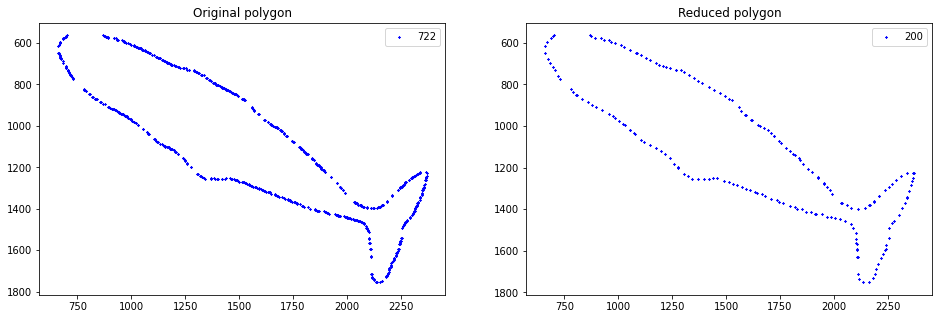

 Original_polygon length: 722
  Reduced_polygon length: 200
Running time: 0.0321 seconds

In [18]:
reduced_polygon = show_result_reducing(polygon=polygon)